# Advanced LLM Evaluation with pytest-evals

This notebook demonstrates advanced techniques for evaluating LLM performance:
1. Running parallel evaluations across multiple models
2. Tracking and comparing results across different runs
3. Visualizing performance trends and model comparisons
4. Statistical analysis of model performance

## Setup
First, let's load required extensions and configure our environment.

In [1]:
%load_ext pytest_evals

## Model Implementation

Define our classifier that leverages different LLM models to determine if text is computer-related.

In [2]:
import openai


def classify(text: str, model="gpt-4o-mini") -> bool:
    """Classify text as computer-related or not using specified LLM model.

    Args:
        text (str): Input text to classify
        model (str): Model identifier (e.g., "gpt-4o", "gpt-4o-mini")

    Returns:
        bool: True if text is computer-related, False otherwise
    """
    resp = openai.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system",
                "content": "Is this text about a computer-related subject? "
                "Reply ONLY with either true or false.",
            },
            {"role": "user", "content": text},
        ],
    )
    return resp.choices[0].message.content.lower() == "true"

## Test Data and Results Tracking

Set up our test cases and initialize our experiment tracking DataFrame.

In [3]:
import pandas as pd

# Define test cases
TEST_DATA = [
    {"text": "I need to debug this Python code", "label": True},
    {"text": "The cat jumped over the lazy dog", "label": False},
    {"text": "My monitor keeps flickering", "label": True},
    {"text": "The weather is nice today", "label": False},
    {"text": "Updating system drivers fixed the issue", "label": True},
    {"text": "the new llama can understand bizzare nuanced slang", "label": True},
]

# Initialize experiment tracking
experiments_df = pd.DataFrame()

## Run Model Evaluations

Execute evaluations across different models and collect detailed metrics.

In [4]:
%%ipytest_evals
import pytest
from collections import defaultdict
from datetime import datetime


@pytest.mark.eval(name="computer_classifier")
@pytest.mark.parametrize("case", TEST_DATA)
@pytest.mark.parametrize("model", ["gpt-4o", "gpt-4o-mini", "gpt-3.5-turbo"])
def test_classifier(case: dict, model, eval_bag):
    """Test individual classification cases across different models.
    
    Args:
        case (dict): Test case with text and expected label
        eval_bag: Container for test results
        classifier: Classification function
        model: Model identifier
    """
    eval_bag.input_text = case["text"]
    eval_bag.label = case["label"]
    eval_bag.prediction = classify(case["text"], model)

    print(f"Model: {model}")
    print(f"Input: {eval_bag.input_text}")
    print(f"Expected: {eval_bag.label}, Predicted: {eval_bag.prediction}\n")

    assert eval_bag.prediction == eval_bag.label


@pytest.mark.eval_analysis(name="computer_classifier")
def test_analysis(eval_results):
    """Analyze results across all models and compute detailed metrics.
    
    Args:
        eval_results: Collection of all test results
    """
    # Group results by model
    res = defaultdict(list)
    for r in eval_results:
        res[r.test_params['model']].append(r)

    global experiments_df
    run_date = datetime.now()

    # Calculate metrics for each model
    for model, results in res.items():
        total = len(results)
        correct = sum(1 for r in results if r.result.prediction == r.result.label)
        accuracy = correct / total

        # Calculate detailed metrics
        true_positives = sum(1 for r in results
                             if r.result.prediction and r.result.label)
        false_positives = sum(1 for r in results
                              if r.result.prediction and not r.result.label)
        false_negatives = sum(1 for r in results
                              if not r.result.prediction and r.result.label)

        print(f"\nModel: {model}")
        print(f"Accuracy: {accuracy:.2%}")
        print(f"True Positives: {true_positives}")
        print(f"False Positives: {false_positives}")
        print(f"False Negatives: {false_negatives}")

        # Store results
        experiments_df = pd.concat([experiments_df, pd.DataFrame([{
            'run_date': run_date,
            'model': model,
            'accuracy': accuracy,
            'test_cases': total,
            'true_positives': true_positives,
            'false_positives': false_positives,
            'false_negatives': false_negatives
        }])], ignore_index=True)

    assert any(model_results['accuracy'].iloc[-1] >= 0.7
               for _, model_results in experiments_df.groupby('model'))


t_627c473c246e4ccca9e56cfeed746cb6.py::test_classifier[gpt-4o-case0] Model: gpt-4o
Input: I need to debug this Python code
Expected: True, Predicted: True

PASSED
t_627c473c246e4ccca9e56cfeed746cb6.py::test_classifier[gpt-4o-case1] Model: gpt-4o
Input: The cat jumped over the lazy dog
Expected: False, Predicted: False

PASSED
t_627c473c246e4ccca9e56cfeed746cb6.py::test_classifier[gpt-4o-case2] Model: gpt-4o
Input: My monitor keeps flickering
Expected: True, Predicted: True

PASSED
t_627c473c246e4ccca9e56cfeed746cb6.py::test_classifier[gpt-4o-case3] Model: gpt-4o
Input: The weather is nice today
Expected: False, Predicted: False

PASSED
t_627c473c246e4ccca9e56cfeed746cb6.py::test_classifier[gpt-4o-case4] Model: gpt-4o
Input: Updating system drivers fixed the issue
Expected: True, Predicted: True

PASSED
t_627c473c246e4ccca9e56cfeed746cb6.py::test_classifier[gpt-4o-case5] Model: gpt-4o
Input: the new llama can understand bizzare nuanced slang
Expected: True, Predicted: False

FAILED
t_6

## Analyze Results

Examine performance metrics and visualize trends across models and runs.

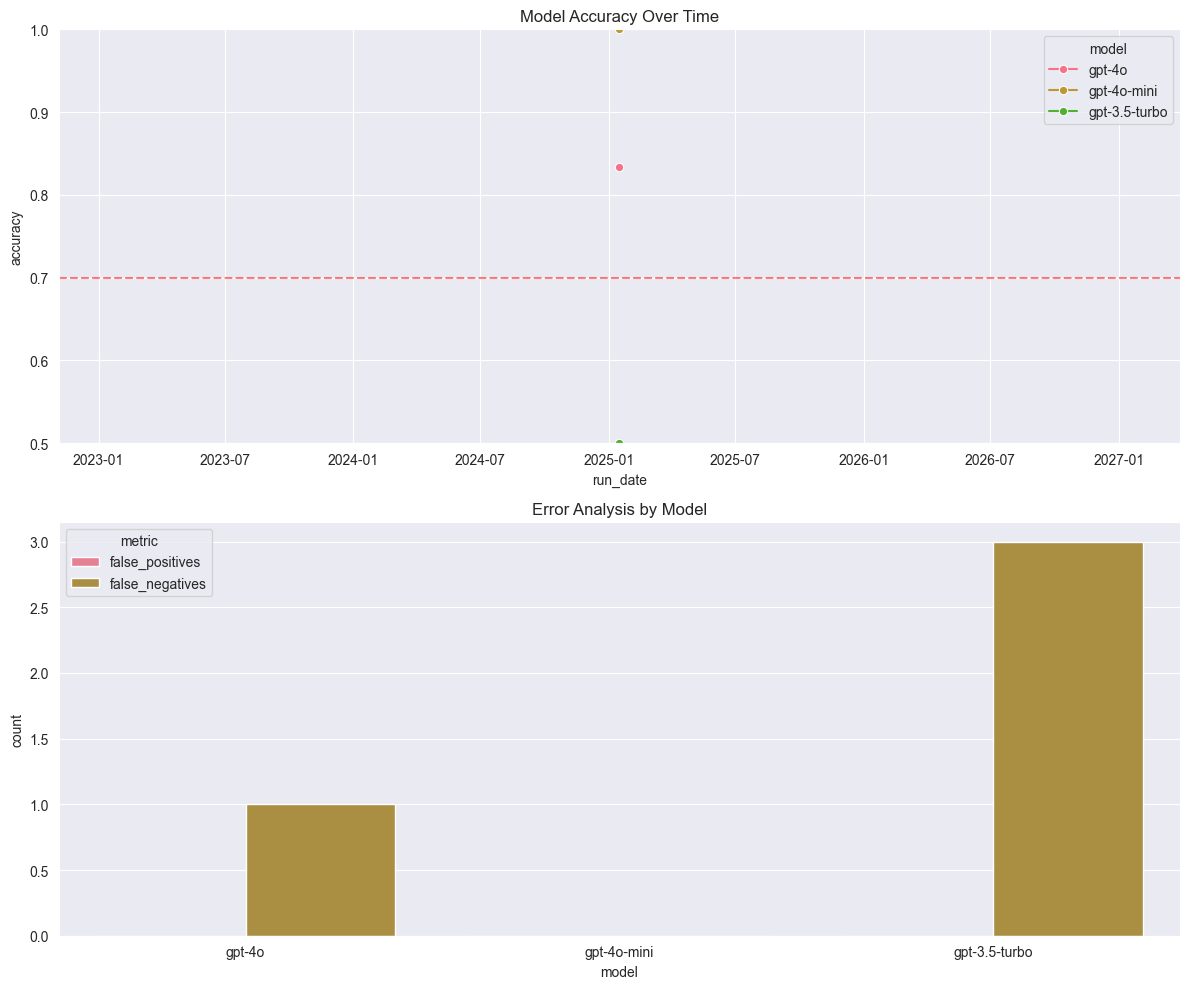


Performance Statistics by Model:


accuracy                                                        \
                 count      mean std       min       25%       50%       75%   
model                                                                          
gpt-3.5-turbo      1.0  0.500000 NaN  0.500000  0.500000  0.500000  0.500000   
gpt-4o             1.0  0.833333 NaN  0.833333  0.833333  0.833333  0.833333   
gpt-4o-mini        1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   

                        true_positives       ... false_positives       \
                    max          count mean  ...             75%  max   
model                                        ...                        
gpt-3.5-turbo  0.500000            1.0  1.0  ...             0.0  0.0   
gpt-4o         0.833333            1.0  3.0  ...             0.0  0.0   
gpt-4o-mini    1.000000            1.0  4.0  ...             0.0  0.0   

              false_negatives                                    
                        count mean std  min  25%  50%  75%  max  
model                                                            
gpt-3.5-turbo             1.0  3.0 NaN  3.0  3.0  3.0  3.0  3.0  
gpt-4o                    1.0  1.0 NaN  1.0  1.0  1.0  1.0  1.0  
gpt-4o-mini               1.0  0.0 NaN  0.0  0.0  0.0  0.0  0.0  

[3 rows x 32 columns]

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_palette("husl")


def plot_performance_comparison():
    """Create comprehensive performance visualization comparing models."""
    if len(experiments_df) > 1:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

        # Plot accuracy trends
        sns.lineplot(
            data=experiments_df,
            x="run_date",
            y="accuracy",
            hue="model",
            marker="o",
            ax=ax1,
        )
        ax1.set_title("Model Accuracy Over Time")
        ax1.axhline(
            y=0.7, color="r", linestyle="--", alpha=0.5, label="Minimum Threshold"
        )
        ax1.set_ylim(0.5, 1.0)

        # Plot error metrics
        error_data = experiments_df.melt(
            id_vars=["model"],
            value_vars=["false_positives", "false_negatives"],
            var_name="metric",
            value_name="count",
        )
        sns.barplot(data=error_data, x="model", y="count", hue="metric", ax=ax2)
        ax2.set_title("Error Analysis by Model")

        plt.tight_layout()
        plt.show()

        # Show summary statistics
        print("\nPerformance Statistics by Model:")
        display(
            experiments_df.groupby("model")[
                ["accuracy", "true_positives", "false_positives", "false_negatives"]
            ].describe()
        )


plot_performance_comparison()

## Save Results

Optionally save experiment results for future analysis.

In [7]:
# Save experiment results
experiments_df.to_csv("experiment_results.csv", index=False)
print("Results saved to 'experiment_results.csv'")

Results saved to 'experiment_results.csv'
